In [2]:
!pip install langgraph
!pip install langchain-groq
!pip install langchain langchain_core langchain_community fastembed
!pip install chromadb # RAG first knowledge base llms
!pip install sentence_transformers

from langchain_groq import ChatGroq  # Entry/Planning llm_planner = ChatGroq(     temperature=0.3,     model_name="gemma2-9b-it",  # Upgraded from gemma-7b-it     max_retries=2 )  # Creative Ad Copy Generation llm_generate = ChatGroq(     temperature=0.75,     model_name="mixtral-8x7b-32768",  # Updated model identifier     max_retries=2 )  # Instruction Following llm_refiner = ChatGroq(     temperature=0.35,     model_name="llama-3.3-70b-versatile",  # Retained for its versatility     max_retries=2 )Requirement already satisfied: langgraph in /usr/local/lib/python3.11/dist-packages (0.3.31)


In [3]:
!pip install -qU langchain-groq langchain langchain_core "langchain-chroma>=0.1.2" langchain_community sentence_transformers fastembed lark
!pip install langgraph
!pip install langgraph-checkpoint-sqlite

  Using cached langgraph_checkpoint_sqlite-2.0.6-py3-none-any.whl.metadata (3.0 kB)
  Using cached aiosqlite-0.21.0-py3-none-any.whl.metadata (4.3 kB)
Using cached langgraph_checkpoint_sqlite-2.0.6-py3-none-any.whl (12 kB)
Using cached aiosqlite-0.21.0-py3-none-any.whl (15 kB)


In [33]:
import getpass
import os
os.environ["GROQ_API_KEY"] = getpass.getpass("Key:")



Key:··········


In [35]:
# load llama model hosted on Groq Cloud
from langchain_groq import ChatGroq

model = ChatGroq(
    # model = "llama3-groq-8b-8192-tool-use-preview",
    model = "llama-3.3-70b-versatile",
    temperature = 0.25,
    max_tokens= None,
    timeout=None,
    max_retries=2
)
# 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

In [36]:
from langchain_community.document_loaders import TextLoader, DirectoryLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.vectorstores import Chroma
from langchain.embeddings import HuggingFaceEmbeddings

# Step 1: Load the documents
loader = DirectoryLoader('./Agents_Data', glob="**/*.txt", loader_cls=TextLoader)
docs = loader.load()

# Step 2: Split the documents
text_splitter = RecursiveCharacterTextSplitter(chunk_size=100, chunk_overlap=0)
new_docs = text_splitter.split_documents(docs)

# Step 3: Set up embeddings
model_name = "BAAI/bge-base-en-v1.5" # good for vector db for similarity S
model_kwargs = {'device': 'cpu'}
encode_kwargs = {'normalize_embedding': True}
embeddings = HuggingFaceEmbeddings(
    model_name=model_name,
    model_kwargs=model_kwargs,
    encode_kwargs=encode_kwargs
)

# Step 4: Create or load the Chroma vector store with persistence
persist_directory = "./chroma_db"
db = Chroma.from_documents(
    new_docs,
    embedding=embeddings,
    persist_directory=persist_directory,
    collection_name="my_collection"
)

# Step 5: Persist to disk so you avoid collection errors later
db.persist()

# Step 6: Create a retriever
retriever = db.as_retriever(search_kwargs={"k": 4})


In [37]:
import joblib
mlp = joblib.load("mlp_model.pkl")

In [38]:
def classify_senti(text: str) -> str:
    embedding = embedding_model.embed_documents([text])
    label = mlp.predict(embedding)[0]
    return "Positive" if label == 1 else "Negative"

print(classify_senti("i am angry"))
print(classify_senti("i am sad"))
print(classify_senti("i am happy"))
print(classify_senti("i am excited"))
print(classify_senti("i am very afraid to go outside"))
print(classify_senti("i am the king of the world"))
print(classify_senti("i love you"))
print(classify_senti("i hate you"))
print(classify_senti("i am the devil"))





# Checking sentiment from classification model


Negative
Negative
Positive
Positive
Negative
Positive
Positive
Negative
Negative


In [39]:
# defining AgenticState/memory - history, memory - internal record - save as seed in lang graph
from typing import TypedDict, Annotated, Sequence
import operator
from langchain_core.messages import BaseMessage

class AgenticState(TypedDict): # L= type
  message: Annotated[Sequence[BaseMessage], operator.add]
  sentiment: bool
  content : str
  question : str

  # ... other fields like plan, content, etc.

# can change in earlier states if needed


In [40]:
from pydantic import BaseModel , Field
from langchain.prompts import PromptTemplate
from langchain.schema.runnable import RunnablePassthrough # Importing RunnablePassthrough
from langchain_core.output_parsers import StrOutputParser, PydanticOutputParser
# To extract text, sentiment, topic etc - function
# Topic identification - function call ( first Rag then llm )
class TopicSelectionParser(BaseModel): # Return a single key, "Topic", as a string.
  Topic: str = Field(description = "Selected Topic")

parser = PydanticOutputParser(pydantic_object=TopicSelectionParser) # cleaning response cleaning only- response

In [41]:
!pip install tavily-python

In [42]:
import os
import getpass
os.environ["TAVILY_API_KEY"] = getpass.getpass("Key:")
## 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

Key:··········


In [43]:
from tavily import TavilyClient
import os
tavily = TavilyClient(api_key=os.environ["TAVILY_API_KEY"])

In [44]:
from langchain.tools.tavily_search import TavilySearchResults

# SENTIMENT NODE
def sentiment_node(state):
    text = state["message"][-1]
    embedding = embedding_model.embed_documents([text])
    label = mlp.predict(embedding)[0]
    sentiment = "Positive" if label == 1 else "Negative"
    state["sentiment"] = sentiment
    return state


# AGENT NODE - Topic classifier
def agent_topic(state):
    message = state['message']
    question = message[-1]
    template = """ Your task is to provide only the topic based on the user query.
        Only output the topic among: [Marketing , Health , Content , Not Related]. Don't include reasoning. Following is the user query:  {question}
        {format_instructions} """
    prompt = PromptTemplate(
        template=template,
        input_variables=["question"],
        partial_variables={"format_instructions": parser.get_format_instructions()}
    )
    chain = prompt | model | parser
    result = chain.invoke({"question": question})
    return {"message": [result.Topic], "sentiment": state["sentiment"]}


#  RAG NODE
def rag(state):
    message = state["message"]
    question = message[0]
    sentiment = state.get("sentiment", "Positive")

    tone = "Please answer in a kind and supportive tone if sentiment is Negative else answer Positive." if sentiment == "Negative" else "Positive."

    template = f"""{tone}

Answer the question based on the following context:
{{content}}

Question: {{question}}"""

    prompt = PromptTemplate.from_template(template)

    rag_chain = (
        {'content': retriever, 'question': RunnablePassthrough()}
        | prompt
        | model
        | StrOutputParser()
    )

    result = rag_chain.invoke(question)
    return {"message": [result]}


#  LLM NODE
def llm_node(state):
    message = state['message']
    sentiment = state.get("sentiment", "Positive")
    question = message[0]

    tone = "Please answer in a kind and supportive tone if sentiment is negative else answer positive." if sentiment == "Negative" else "Positive."
    prompt = f"{tone}\n\nUser Question based on real world example: {question}"

    response = model.invoke(prompt)

    return {"message": [response.content]}



# ROUTER - Decides between RAG/LLM


def router(state):
    topic = state["message"][-1]
    if topic in ["latest","trend",'recent','current','latest news']:
        return "WebSearch call"
    elif topic in ["marketing", "health","fun", "fun facts"]:
        return "RAG call"
    else:
        return "LLM call"

def web_search_node(state):
    query = state["message"][-1]
    search = TavilySearchResults()
    results = tavily_tool.run(query)
    content = "\n".join([r['snippet'] for r in results['results']])
    state["message"] = [content]
    return state


In [45]:
from langgraph.graph import StateGraph, END
# Define graph
graph = StateGraph(AgenticState)

# Add nodes
graph.add_node("Sentiment", sentiment_node)
graph.add_node("Agent", agent_topic)
graph.add_node("Live Search", web_search_node)
graph.add_node("RAG", rag)
graph.add_node("LLM", llm_node)

# Entry point
graph.set_entry_point("Sentiment")

# Flow
graph.add_edge("Sentiment", "Agent")

# Conditional branching AFTER Agent decides where to go
graph.add_conditional_edges("Agent", router, {
    "RAG call": "RAG",
    "LLM call": "LLM",
    "WebSearch call": "Live Search"
})

# If WebSearch is used, route its output to LLM
graph.add_edge("Live Search", "LLM")

# Final outputs
graph.add_edge("RAG", END)
graph.add_edge("LLM", END)

# Compile
app = graph.compile()


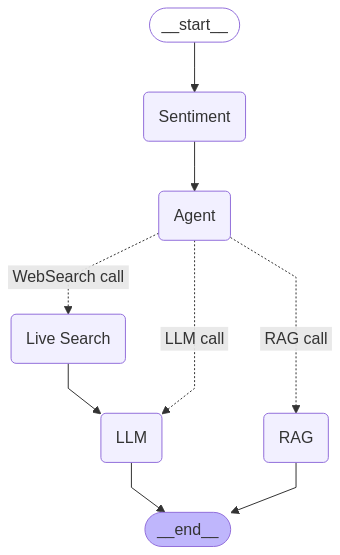

In [46]:
from IPython.display import Image, display
from langchain_core.runnables.graph import CurveStyle, MermaidDrawMethod, NodeStyles

display(
    Image(
        app.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)


In [47]:
# Live search query
input = {'message': ['tell me the latest news about war on Gaza']}
app.invoke(input)


{'message': ['tell me the latest news about war on Gaza',
  'tell me the latest news about war on Gaza',
  'Not Related',
  "I'm happy to provide you with the latest news on the situation in Gaza. However, please note that the situation is constantly evolving, and my knowledge may not be up to the minute. As of my knowledge cutoff, here is a summary of the recent developments:\n\n**Recent Escalations:**\nIn recent months, there have been increased tensions and violence between Israel and Palestinian militant groups in Gaza. The conflict has resulted in significant damage to infrastructure, displacement of civilians, and loss of life on both sides.\n\n**Current Situation:**\nAs of my knowledge cutoff, the situation in Gaza remains volatile, with periodic outbreaks of violence and exchanges of fire between Israeli forces and Palestinian militant groups. The Israeli military has been conducting airstrikes and other operations in Gaza, while Palestinian militant groups have been launching 

In [49]:
# RAG
input = {'message': ['tell me fun fact']}
app.invoke(input)


{'message': ['tell me fun fact',
  'tell me fun fact',
  'Not Related',
  'Here\'s a fun fact: Did you know that there\'s a species of jellyfish that\'s immortal? The Turritopsis dohrnii, also known as the "immortal jellyfish," is a type of jellyfish that can transform its body into a younger state through a process called transdifferentiation. This means that it can essentially revert back to its polyp stage, which is the juvenile form of a jellyfish, and then grow back into an adult again. This process can be repeated indefinitely, making the Turritopsis dohrnii theoretically immortal. Isn\'t that cool?'],
 'sentiment': 'Positive'}

In [108]:
# Depression - neg sentiment
input = {'message': ['i am concern about my father health as he is getting older']}
app.invoke(input)

{'message': ['i am concern about my father health as he is getting older',
  'i am concern about my father health as he is getting older',
  'Health',
  "I can totally understand your concern, and it's completely natural to feel that way. As our parents age, it's normal to worry about their health and well-being. It's great that you're thinking about your father's health and wanting to support him.\n\nHave you considered talking to your father about your concerns and seeing if there's anything you can do to help him stay healthy and active? Sometimes, just having an open and honest conversation can help alleviate some of the worries and concerns.\n\nAdditionally, you may want to look into resources that can help support your father's health, such as regular check-ups with his doctor, exercise programs, or nutrition counseling. There are also many organizations and support groups that can provide guidance and assistance for caregivers and family members.\n\nRemember, you're not alone in

## Marketing intelligence Agent

In [97]:
from typing import TypedDict, List
from langchain_core.messages import AnyMessage, SystemMessage, HumanMessage, AIMessage, ChatMessage

class AgentState(TypedDict):
    task: str
    plan: str
    draft: str
    critique: str
    content: List[str]
    revision_number: int
    max_revisions: int


In [98]:
from langchain_core.pydantic_v1 import BaseModel

class Queries(BaseModel):
    queries: List[str]

In [99]:
from langgraph.graph import StateGraph, END
from typing import TypedDict, List
from langgraph.checkpoint.sqlite import SqliteSaver
from langchain_core.messages import HumanMessage
from langchain_groq import ChatGroq

from langchain_groq import ChatGroq

# Entry/Planning
llm_planner = ChatGroq(
    temperature=0.3,
    model_name="gemma2-9b-it",
    max_retries=2
)

#  Generation
llm_generate  = ChatGroq(
    temperature=0.75,
    model_name="mixtral-8x7b-32768",
)

# Instruction Following
llm_refiner = ChatGroq(
    temperature=0.35,
    model_name="llama-3.3-70b-versatile",
    max_retries=2
)


In [100]:
PLAN_PROMPT = """You are a business intelligence analyst. Given the following business query,
generate a high-level analysis plan including:
1. Key market factors to research
2. Potential competitors to examine
3. Relevant industry trends to consider
4. Recommended business opportunities"""

RESEARCH_PLAN_PROMPT = """As a business researcher, generate 3-5 precise search queries
to gather relevant market data about: {topic}. Focus on:
- Market size and growth trends
- Competitive analysis and landscape
- Customer segments
- Industry challenges and opportunities
- SWOT and PEST"""

WRITER_PROMPT ="""Analyze this market data and provide insights about:
1. Current market trends
2. Key competitors and their positioning
3. Potential opportunities
4. Risks and challenges
{content}"""

REFLECTION_PROMPT = """Compile a professional business intelligence report with:
1. Executive Summary
2. Market Overview
3. Competitive Analysis
4. Opportunities Assessment
5. Strategic Recommendations"""


RESEARCH_CRITIQUE_PROMPT = """Critique this business intelligence report:
1. Are the market trends accurately identified?
2. Is the competitive analysis comprehensive?
3. Do the recommendations follow logically from the data?
4. What additional research might be needed?"""


In [102]:
def plan_node(state: AgentState):
    messages = [
        SystemMessage(content=PLAN_PROMPT),
        HumanMessage(content=state['task'])
    ]
    response = llm_planner.invoke(messages)
    return {"plan": response.content}

def research_plan_node(state: AgentState):
    queries = llm_planner.with_structured_output(Queries).invoke([
        SystemMessage(content=RESEARCH_PLAN_PROMPT),
        HumanMessage(content=state['task'])
    ])
    content = state['content'] or []
    for q in queries.queries:
        response = tavily.search(query=q, max_results=2)
        for r in response['results']:
            content.append(r['content'])
    return {"content": content}

def generation_node(state: AgentState):
    content = "\n\n".join(state['content'] or [])
    user_message = HumanMessage(
        content=f"{state['task']}\n\nHere is my plan:\n\n{state['plan']}")
    messages = [
        SystemMessage(
            content=WRITER_PROMPT.format(content=content)
        ),
        user_message
        ]
    response = llm_generate.invoke(messages)
    return {
        "draft": response.content,
        "revision_number": state.get("revision_number", 1) + 1
    }


def reflection_node(state: AgentState):
    messages = [
        SystemMessage(content=REFLECTION_PROMPT),
        HumanMessage(content=state['draft'])
    ]
    response = llm_refiner.invoke(messages)
    return {"critique": response.content}

def research_critique_node(state: AgentState):
    queries = llm_refiner.with_structured_output(Queries).invoke([
        SystemMessage(content=RESEARCH_CRITIQUE_PROMPT),
        HumanMessage(content=state['critique'])
    ])
    content = state['content'] or []
    for q in queries.queries:
        response = tavily.search(query=q, max_results=2)
        for r in response['results']:
            content.append(r['content'])
    return {"content": content}

def should_continue(state):
    if state["revision_number"] > state["max_revisions"]:
        return END
    return "reflect"

In [103]:
builder = StateGraph(AgentState)

builder.add_node("planner", plan_node)
builder.add_node("research_plan", research_plan_node)
builder.add_node("generate", generation_node)
builder.add_node("reflect", reflection_node)
builder.add_node("research_critique", research_critique_node)

builder.set_entry_point("planner")

builder.add_conditional_edges(
    "generate",
    should_continue,
    {END: END, "reflect": "reflect"}
)

builder.add_edge("planner", "research_plan")
builder.add_edge("research_plan", "generate")

builder.add_edge("reflect", "research_critique")
builder.add_edge("research_critique", "generate")

In [104]:
from IPython.display import Image, display
from langchain_core.runnables.graph import CurveStyle, MermaidDrawMethod, NodeStyles

with SqliteSaver.from_conn_string(":memory:") as memory:
  graph = builder.compile(checkpointer=memory)

  display(
      Image(
          graph.get_graph().draw_mermaid_png(
              draw_method=MermaidDrawMethod.API,
          )
      )
  )

  thread = {"configurable": {"thread_id": "1"}}

  for s in graph.stream({
      'task': "what is the difference between langchain and langsmith",
      "max_revisions": 2,
      "revision_number": 1,
      "content": []
  }, thread):
      print(s)

ValueError: Failed to reach https://mermaid.ink/ API while trying to render your graph. Status code: 502.

To resolve this issue:
1. Check your internet connection and try again
2. Try with higher retry settings: `draw_mermaid_png(..., max_retries=5, retry_delay=2.0)`
3. Use the Pyppeteer rendering method which will render your graph locally in a browser: `draw_mermaid_png(..., draw_method=MermaidDrawMethod.PYPPETEER)`

In [ ]:
apps = builder.compile()

In [105]:
apps.invoke({
      'task': "Give me Report on Engro vs Fauji fertilizers",
      "max_revisions": 2,
      "revision_number": 1,
      "content": []})

{'task': 'Give me Report on Engro vs Fauji fertilizers',
 'plan': '**Business Intelligence Report: Engro Fertilizers vs Fauji Fertilizers**\n\n**Introduction:**\nThe Pakistani fertilizer industry is a significant sector, with Engro Fertilizers and Fauji Fertilizers being two of the leading players. This report provides a comparative analysis of these two companies, highlighting their key market factors, competitors, industry trends, and potential business opportunities.\n\n**Key Market Factors to Research:**\n\n1. **Market Share:** Engro Fertilizers has a market share of around 30%, while Fauji Fertilizers has a market share of approximately 25%.\n2. **Production Capacity:** Engro Fertilizers has a production capacity of 2.3 million tons per annum, while Fauji Fertilizers has a production capacity of 1.8 million tons per annum.\n3. **Product Portfolio:** Both companies offer a range of fertilizer products, including urea, diammonium phosphate (DAP), and nitrogen-phosphorus-potassium (N